## Connect to Azure Quantum workspace

In [1]:
from qiskit import QuantumCircuit
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
from os import getenv
 
workspace = Workspace.from_connection_string(getenv('AZUREQ_STRING'))
 
provider = AzureQuantumProvider(workspace)

ionq_sim = provider.get_backend('ionq.simulator')
quantinuum_sim = provider.get_backend('quantinuum.sim.h1-1e')
rigetti_sim = provider.get_backend('rigetti.sim.qvm')
 
# Set the backend you want to use here.
# WARNING: Quantinuum simulator usage is not unlimited. Running this sample against it could consume a significant amount of your eHQC quota.
backend = ionq_sim

## Import data

In [2]:
import pandas as pd
fault_data = pd.read_csv("EngineDBdata.csv")

# Random values chosen right now for time's sake: 
fault_data = fault_data.groupby('Fault')\
    .apply(lambda x: x.sample(min(len(x), 10)))\
        .reset_index(drop=True)
 
features = fault_data.iloc[:, 1:].values
labels = fault_data.iloc[:, 0].values
 
fault_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Fault                40 non-null     int64  
 1   MAP                  40 non-null     float64
 2   TPS                  40 non-null     float64
 3   Force                40 non-null     float64
 4   Power                40 non-null     float64
 5   RPM                  40 non-null     float64
 6   Consumption L/H      40 non-null     float64
 7   Consumption L/100KM  40 non-null     float64
 8   Speed                40 non-null     float64
 9   CO                   40 non-null     float64
 10  HC                   40 non-null     float64
 11  CO2                  40 non-null     float64
 12  O2                   40 non-null     float64
 13  Lambda               40 non-null     float64
 14  AFR                  40 non-null     float64
dtypes: float64(14), int64(1)
memory usage: 4.8

C:\Users\PivotportLab\AppData\Local\Temp\ipykernel_12240\3007151003.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 10)))\


## Preprocessing data

In [3]:
from sklearn.preprocessing import MinMaxScaler
features = MinMaxScaler().fit_transform(features)

Peek at features. They have been normalized to be [0,1] range.

In [4]:
#max(features[10])

## Make the plot

In [5]:
import pandas as pd
import seaborn as sns

# sns.pairplot(fault_data, hue="Fault", palette="tab10")

## Training a Classical Machine Learning Model - Support Vector Classifier (SVC)

Splitting testing and training data: 

In [6]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

Train SVC: 

In [7]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

Check scores/performance: 

In [8]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.78
Classical SVC on the test dataset:     0.38


Already reaching paper accuracy. Great!

## Training a Quantum Machine Learning Model - Variational Quantum Classifier (VQC)

This circuit will take in our data, and execute these quantum calculations on this matrix. Will output classical results. 

Note: qubits here need to be swapped here for them to "see" each other. Increases need for computatonal power. 

In [9]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

Plotting our ansatz. Related to the trainable weights of the classifier.

Note: Ry = y-rotation

In [10]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

## Optimization algorithm:

In [11]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=50) 
# Experiment w/ no of iterations. 
# (!!) Sometimes accuracy tapers off after certain no of iterations

** Note: A lot of the work goes into the "cost analysis" of our classifier. Preprocessing data, optimization algo, cutting data, training time/running time for quantum algo, min accuracy we'd be satisfied with...

Without this, we would not iterate through the gradient descent, and would not have a trained model.



## Determine where to train classifier

Here, we can choose a simulator or quantum provider

In [12]:
#from qiskit.primitives import Sampler
from qiskit.primitives import Sampler, BackendSampler
 
sampler = Sampler()
backend_sampler = BackendSampler(backend)

# Simulator used to run circuit

# (!!) Here, we will swap it out w/ real quantum device
# ie, provider call

Add callback function

In [13]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## We are using VQC here, and constructing it

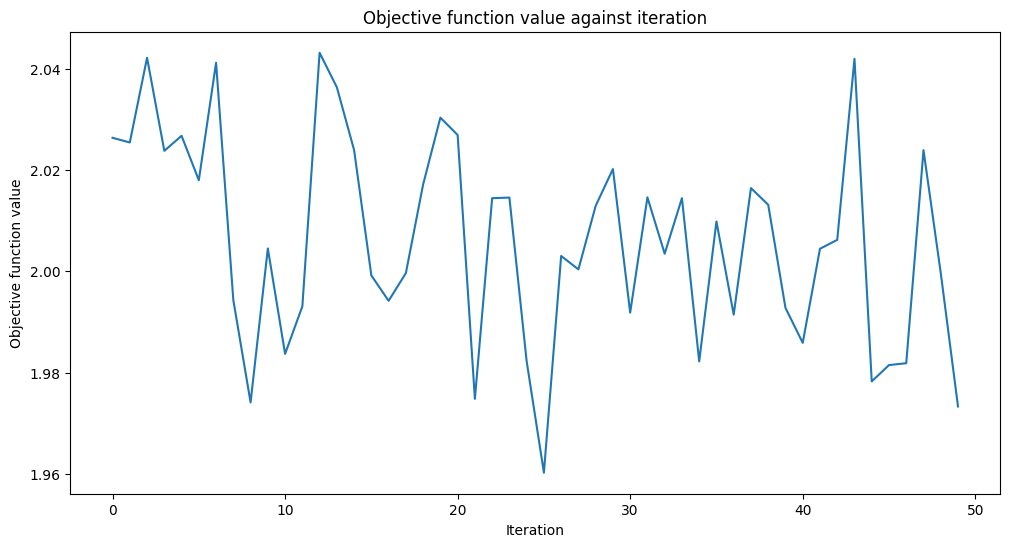

Training time: 6574 seconds


In [14]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    #sampler=sampler, # we would change this to q provider later
    sampler=backend_sampler,
    feature_map=feature_map, # zz map
    ansatz=ansatz, # weights
    optimizer=optimizer, # 
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()

vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


How VQC performs on our dataset: 

In [15]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

.............................................................................................Quantum VQC on the training dataset: 0.12
Quantum VQC on the test dataset:     0.62


Note: Can loop to tweak gradient descent and iterations to improve results

## Feature reduction

(!!) Considerations: 
- Should we reduce no features?
- Big idea: why QML? 
- Focus on relavent features (like removing either RPM or Speed bc they are linearly related)
- ** This is very important work for the programmer and tweaking the model for our unique uses

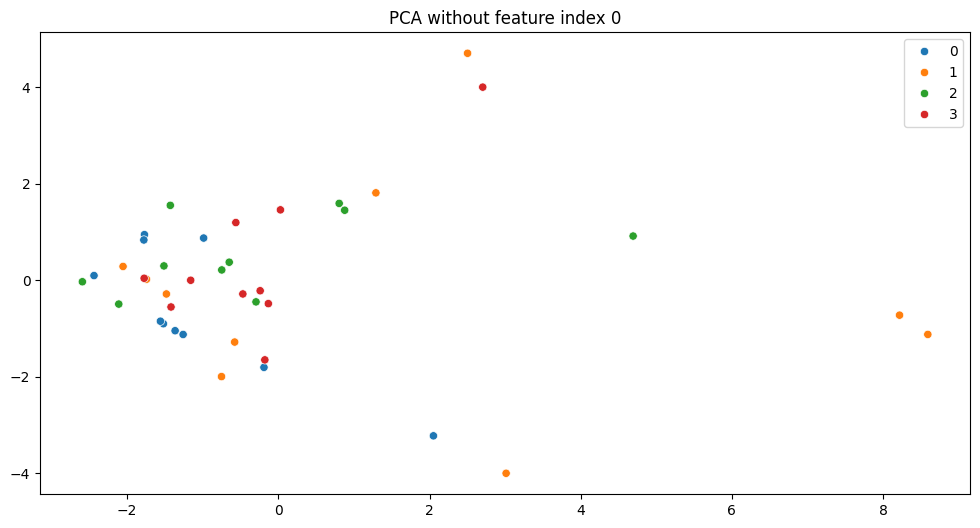

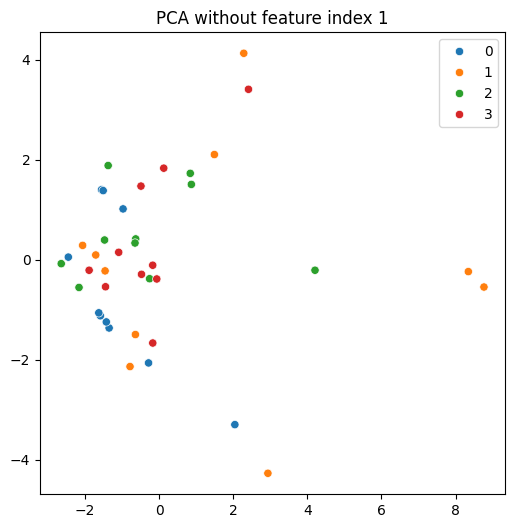

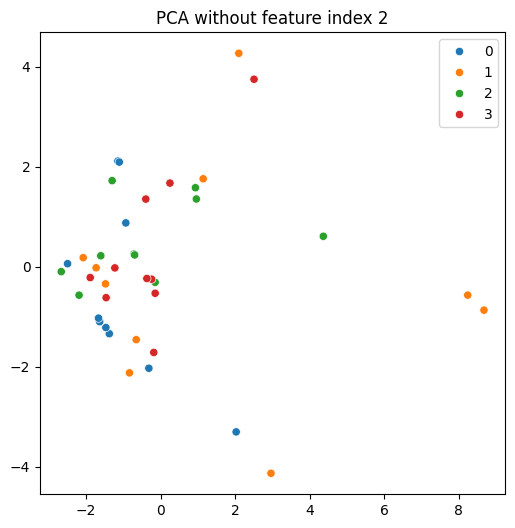

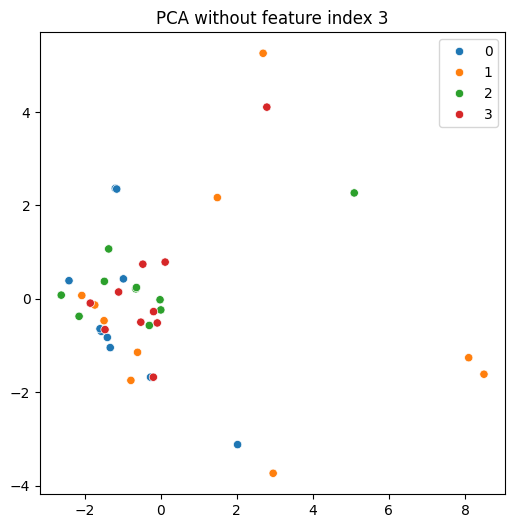

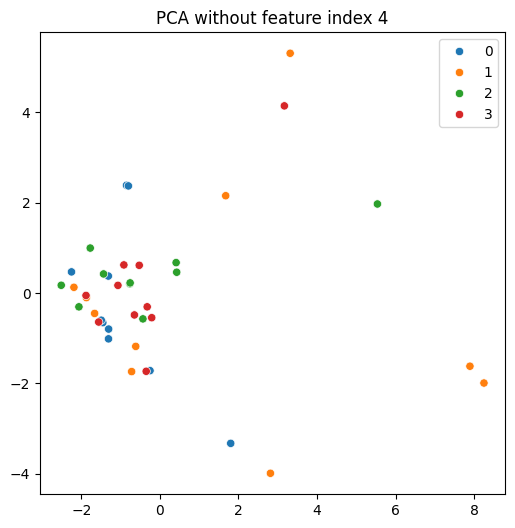

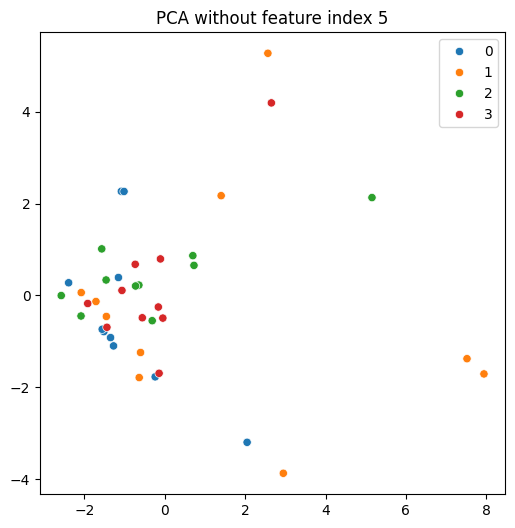

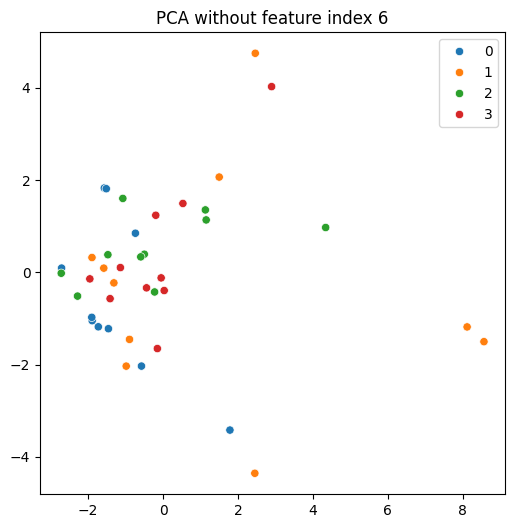

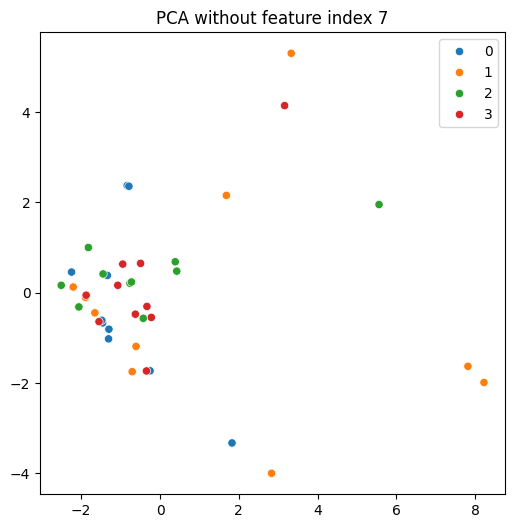

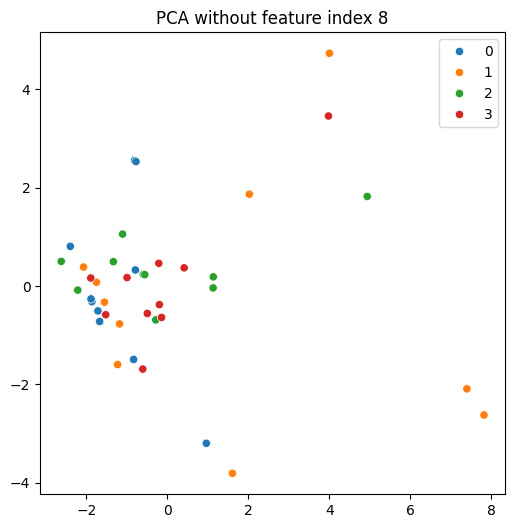

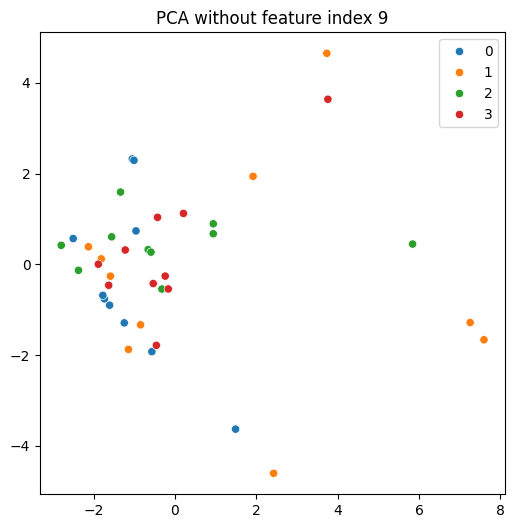

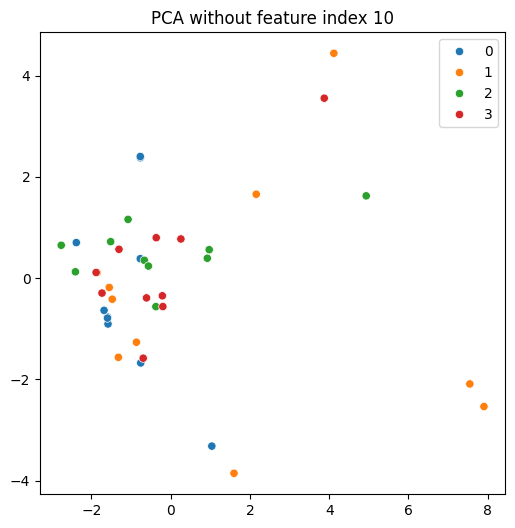

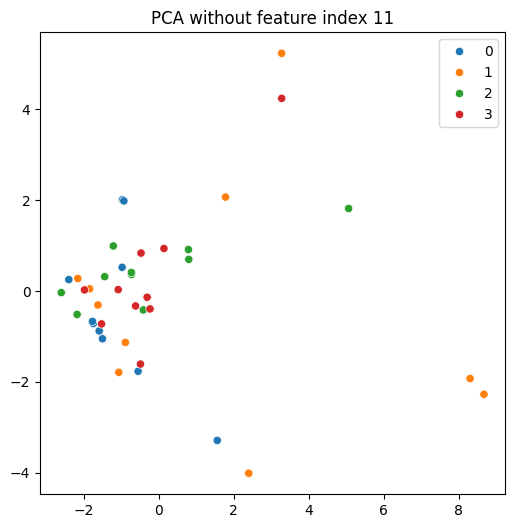

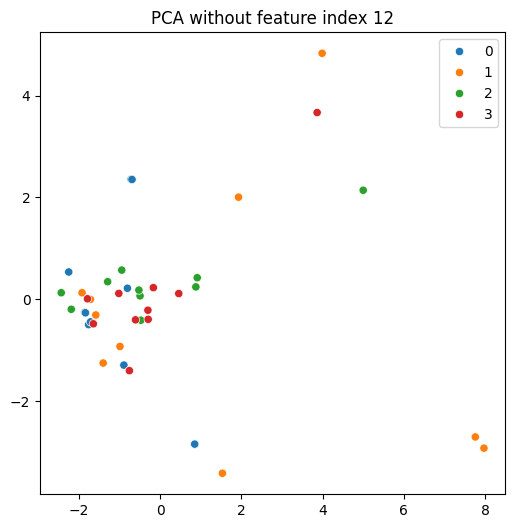

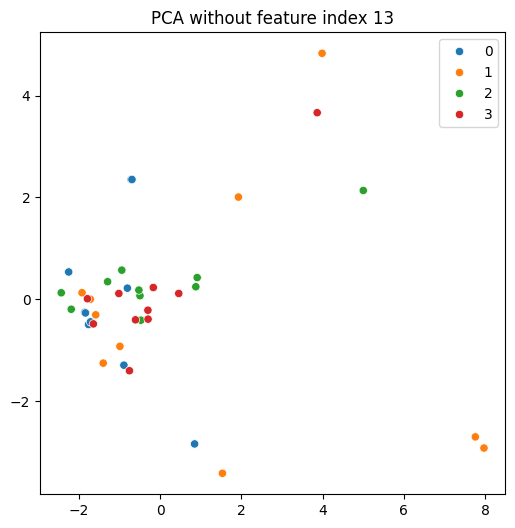

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'features' and 'labels' are already defined and preprocessed in your notebook

# Standardize the features if not already done
scaler = StandardScaler()
features = scaler.fit_transform(features)

def evaluate_pca_without_feature(features, labels, feature_idx_to_drop):
    # Drop the specified feature
    features_modified = np.delete(features, feature_idx_to_drop, axis=1)
    
    # Apply PCA
    pca = PCA(n_components=2)
    transformed_features = pca.fit_transform(features_modified)
    
    # Plotting
    plt.figure()
    plt.rcParams["figure.figsize"] = (6, 6)
    sns.scatterplot(x=transformed_features[:, 0], y=transformed_features[:, 1], hue=labels, palette="tab10")
    plt.title(f'PCA without feature index {feature_idx_to_drop}')
    plt.show()

# Loop through each feature and evaluate
num_features = features.shape[1]

for i in range(num_features):
    evaluate_pca_without_feature(features, labels, i)
